# Sky-rocketing Prices & Inflation- An Analysis using GridDB and Python

<img src="Desktop\Work\Work_Upwork\Israel Imru_GridDB\Python_GridDB_POC2\inflation_pic.jpg" width=600 height=600 />

<a href="https://www.vecteezy.com/free-photos"><center>Image Credit: Free Stock photo from Vecteezy</a>

## Overview

In recent times, the popularity of the search terms 'Inflation', 'Shortage', 'Food Prices' and 'Gas Prices' have gone up by 100-140 % (Source: Google Trends). There's no doubt that people all over the world are worried about food and gas prices going up. It goes without saying that sky-rocketing and inflated prices of commodities like food, gasoline and household fuels can have a cataclysmic effect on the quality of life, especially affecting small families. Hence, it is important to analyze and stay informed of the trends in prices of commodities for sustenenance and survival. GridDB and Python together will be used in this crucial analysis. 

### About the Dataset

The dataset in hand is a time series dataset obtained from the <a href="https://www.bls.gov/">U.S Bureau Labor of Statistics</a>. The Dataset can be downloaded <a href="https://www.bls.gov/cpi/data.htm">here</a>. Download the text files from the 'Average Price Data' section in the website (highlighted below).

<img src="Desktop\Work\Work_Upwork\Israel Imru_GridDB\Python_GridDB_POC2\CPI_Screenshot_Final.jpg" width=800 height=800 />

The text files highlighted in the image below have been used for the analysis -

<img src="Desktop\Work\Work_Upwork\Israel Imru_GridDB\Python_GridDB_POC2\Text_Files_to_be_downloaded.jpg" width=600 height=600 /> 


### Planning the load process to GridDB/Understanding the Size of the Dataset 

It's important to understand the size of the dataset so that we can plan out the process to load the data into GridDB. This is important so as to not put a huge burden on the system where the program is running (client system). The datasets have more than 40 years of data which gives us good scope to do some analysis on price trends. 

In [ ]:
import os
import numpy as np
import pandas as pd
import nums_from_string as ns
from IPython.core.display import Image, display
import seaborn as sns
from matplotlib import pyplot as plt


Note that these text files are fixed width files. Hence, the fixed width files need to be downloaded using the read_fwf function of pandas. 

In [16]:
household_prices = pd.read_fwf('ap.data.1.HouseholdFuels.txt')
gasoline_prices = pd.read_fwf('ap.data.2.Gasoline.txt')
food_prices = pd.read_fwf('ap.data.3.Food.txt')

Let's now look at the memory utilized by the dataframes.

In [17]:
print('Size of household_prices', household_prices.info(memory_usage='deep'))
print('Size of food_prices', food_prices.info(memory_usage='deep'))
print('Size of gasoline_prices', gasoline_prices.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103139 entries, 0 to 103138
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   series_id       103139 non-null  object 
 1   year            103139 non-null  int64  
 2   period          103139 non-null  object 
 3   value           103139 non-null  object 
 4   footnote_codes  0 non-null       float64
dtypes: float64(1), int64(1), object(3)
memory usage: 20.4 MB
Size of household_prices None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139986 entries, 0 to 139985
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   series_id       139986 non-null  object 
 1   year            139986 non-null  int64  
 2   period          139986 non-null  object 
 3   value           139986 non-null  object 
 4   footnote_codes  0 non-null       float64
dtypes: float64(1), int64(1), object(3)
memo

As seen above, the size of the 'household_prices', 'food_prices' and 'gasoline_prices' datasets when loaded into memory are 22.7MB, 28.7 MB and 18.5 MB respectively. This brings us to a total of 69.9 MB. Hence, an efficient load strategy would be needed while loading the data into GridDB. 

In [18]:
print(len(household_prices))
print(len(gasoline_prices))
print(len(food_prices))

103139
88754
139986


The above gives us a reference to the number of records that will be processed/loaded into GridDB. 

An efficient load strategy would be to chunk the data into 1000 rows each and load them into GridDB one chunk at a time. This will result in multiple invocations of the GridDB API to load the data. But this will allow us greater control on the data being loaded. ALternatively, the entire data can be loaded in one shot too but that may utilize a lot of memory and bandwidth (ensure that any timeouts on the HTTP connection are configured leniently in this case). 

### Data Cleaning

Let's perform some data cleaning before loading the data into GridDB. <br/>
First, let's add a "Category" field that will store the type of data. This way we are able to identify the source of a record in case that is needed in the future. 

In [19]:
household_prices['Category'] = 'Household Commodities'
gasoline_prices['Category'] = 'Gasoline'
food_prices['Category'] = 'Food'

Let's now define a function that will remove unneeded columns, extract the month number from the period field, perform data cleaning in the value field to ensure that all data is numeric and finally, order the columns in the dataframe. <br/>
Once done, we will invoke this function against the 3 datasets (dataframes) that were loaded. 

In [20]:
def data_cleaning (df):
    df.drop('footnote_codes', axis=1, inplace=True) # Delete the column 'footnote_codes'
    df['month'] = df['period'].str[-2:] #extract the month
    # DataType conversions
    df["month"] = pd.to_numeric(df["month"]) #convert to number
    df["value"] = df["value"].replace(['-'],0) #Replace values that have a '-' to a 0
    df["value"] = pd.to_numeric(df["value"]) #convert to number
    cols = list(df.columns.values)
    df = df[['series_id', 'year', 'period', 'value', 'month', 'Category']] #order the columns in the dataframe
    return df

In [21]:
#Invoke the cleaning function on the 3 dataframes
household_prices = data_cleaning(household_prices)
gasoline_prices = data_cleaning(gasoline_prices)
food_prices = data_cleaning(food_prices)

### Creating a Container structure in GridDB

Refer to <a href="https://griddb.net/en/blog/griddb-webapi/">GRIDDB WebAPI</a> to know more about creating containers in GridDB. <br/><br/>
We will now proceed with creating a container in GridDB to hold the data. 

In [22]:
import requests  # to make http calls
import http
http.client.HTTPConnection.debuglevel = 1 #Tip - to enable detailed logging of http calls; this is not needed in case you don't detailed logging

In [23]:
#Construct an object to hold the request headers (ensure that you replace the XXX placeholder with the correct value that matches the credentials for your GridDB instance)
header_obj = {"Authorization":"XXX","Content-Type":"application/json; charset=UTF-8","User-Agent":"PostmanRuntime/7.29.0"}

#Construct the base URL based on your GRIDDB cluster you'd like to connect to (ensure that you replace the placeholders in the URL below with the correct values that correspond to your GridDB instance)
base_url = 'https://[host]:[port]/griddb/v2/[clustername]/dbs/[database_name]'

In [ ]:
#Construct an object to hold the request body (i.e., the container that needs to be created)
data_obj = {
    "container_name": "Inflation_CPI_Analysis",
    "container_type": "COLLECTION",
    "rowkey": False,
    "columns": [
    {
    "name": "series_id",
    "type": "STRING"
    },
    {
    "name": "year",
    "type": "INTEGER"
    },
    {
    "name": "period",
    "type": "STRING"
    },
    {
    "name": "value",
    "type": "FLOAT"
    },
    {
    "name": "month",
    "type": "INTEGER"
    },
    {
    "name": "category",
    "type": "STRING"
    }        
    ]
}

#Set up the GridDB WebAPI URL
url = base_url + '/containers'

#Invoke the GridDB WebAPI with the headers and the request body
x = requests.post(url, json = data_obj, headers = header_obj)

The container that will store all the data has now been created in GridDB. Note that I set rowkey to False as the series_id field will not be unique as we have the same item occurring multiple times in the dataset (for each month and year).

## Adding data to the container in GridDB/Registering rows

### Loading Strategy: Creating Data Chunks

The below function converts a dataframe into a JSON object and then chunks it into lots of 1000 rows.

In [11]:
#Setup the URL to be used to invoke the GridDB WebAPI to register rows in the container created previously
url = base_url + '/containers/Inflation_CPI_Analysis/rows'

def create_chunks_to_load_to_GRIDDB(df):
    list_of_dataframes = np.array_split(df, len(df)/1000) #Returns a list of dataframes; here,# the chunk size is 1000
    for i in list_of_dataframes:
        df_json = i.to_json(orient='values')
        request_body = df_json
        x = requests.put(url, data=request_body, headers=header_obj) #Invoke the GridDB WebAPI using the request constructed
        print(x.text)

We will now load the 3 datasets that we have using the function that chunks the data and loads it into GridDB

In [ ]:
create_chunks_to_load_to_GRIDDB(household_prices)

In [ ]:
create_chunks_to_load_to_GRIDDB(food_prices)

In [ ]:
create_chunks_to_load_to_GRIDDB(household_prices)

## Quick Validation & Introduction to TQL

Now that we've loaded data, we are good to proceed with the analysis. For the purpose of this analysis, we use GRIDDB's query language called TQL. To know more on TQL, check out this <a href =  "https://griddb.net/en/blog/griddb-query-language/"> resource </a>. There are also some Youtube video tutorials to grasp TQL quickly. Click <a href = "https://www.youtube.com/watch?v=-PCQUUimQEM">here </a> for one such video tutorial. Follow the <a href = "https://griddb.net/en/blog/griddb-webapi/"> GridDB WebAPI guide </a> (Refer to the section 'Fetching Data') to learn the basic structure of a request for a TQL statement. 

The below TQL query does a quick check to see if the number of records inserted into GridDB is the same as the sum of the records in the 3 dataframes used for the data load.

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/tql'

#Construct the request body which has the TQL that is to be used to retrieve the data
#Use the count function to get the number of records in the container 
request_body = '[{"name":"Inflation_CPI_Analysis", "stmt":"SELECT count(*) ", "columns":[]}]' 


#Invoke the GridDB WebAPI
x = requests.post(url, data=request_body, headers=header_obj)

In [25]:
print(x.text)

[{"columns":[{"name":"aggregationResult","type":"DOUBLE"}],"results":[[331879.0]]}]


In [26]:
print(len(household_prices) + len(food_prices) + len(gasoline_prices))

331879


 <b><justify> ✅ - This confirms that all data loaded into the database has been successfuly loaded.</justify> </b>

# Loading the mapping tables as dataframes

Below are the mapping files to be downloaded. <img src="Desktop\Work\Work_Upwork\Israel Imru_GridDB\Python_GridDB_POC2\Mapping_tables_1.jpg" width=400 height=400 />

<b> Note that all files are tab separated files. These mapping files can be used to lookup code descriptions if needed. These are going to remain in Python and not going to be loaded into GridDB.</b>

In [27]:
item_mapping = pd.read_csv('ap.item_mapping.txt',sep='\t')
period_mapping = pd.read_csv('ap.period_mapping.txt',sep='\t')
seasonal_mapping = pd.read_csv('ap.seasonal_mapping.txt',sep='\t')
area_mapping = pd.read_csv('ap.area_mapping.txt',sep='\t')
series_mapping = pd.read_csv('ap.series_mapping.txt',sep='\t')

# Time Series Trends Analysis

## Scenario 1: How has inflation impacted the price of Rice?

<b> Writing a query to gather data for series_id APU0000701311 (Rice, white, long grain, precooked); APU0000701312 (Rice, white, long grain, uncooked). Note that each is of 1 pound weight. They are not seasonally adjusted. </b>

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/tql'

#Construct the request body which has the TQL that is to be used to retrieve the data
# Getting data for series_id APU0000701311 (Rice, white, long grain, precooked); APU0000701312 (Rice, white, long grain, uncooked)
request_body = '[{"name":"Inflation_CPI_Analysis", "stmt":"SELECT * WHERE series_id = \'APU0000701311\' OR series_id = \'APU0000701312\'", "columns":[]}]' 

#Invoke the GridDB WebAPI
data_req1 = requests.post(url, data=request_body, headers=header_obj)
data_req1

We will process the response received from the GridDB WebAPI invocation and construct a dataframe with the data from the response. <br/>
Once done, we will group the data by the year field so that we have the mean values for each year. This can then be plotted to see the trend in a visual manner. 

In [30]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req1.json()
Rice_trends = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"], myJson[0]["columns"][2]["name"], myJson[0]["columns"][3]["name"],myJson[0]["columns"][4]["name"],myJson[0]["columns"][5]["name"]])

In [31]:
#Group the data by year and get the mean for each year
Avg_value_rice = pd.DataFrame(Rice_trends.groupby(['year'])['value'].mean())

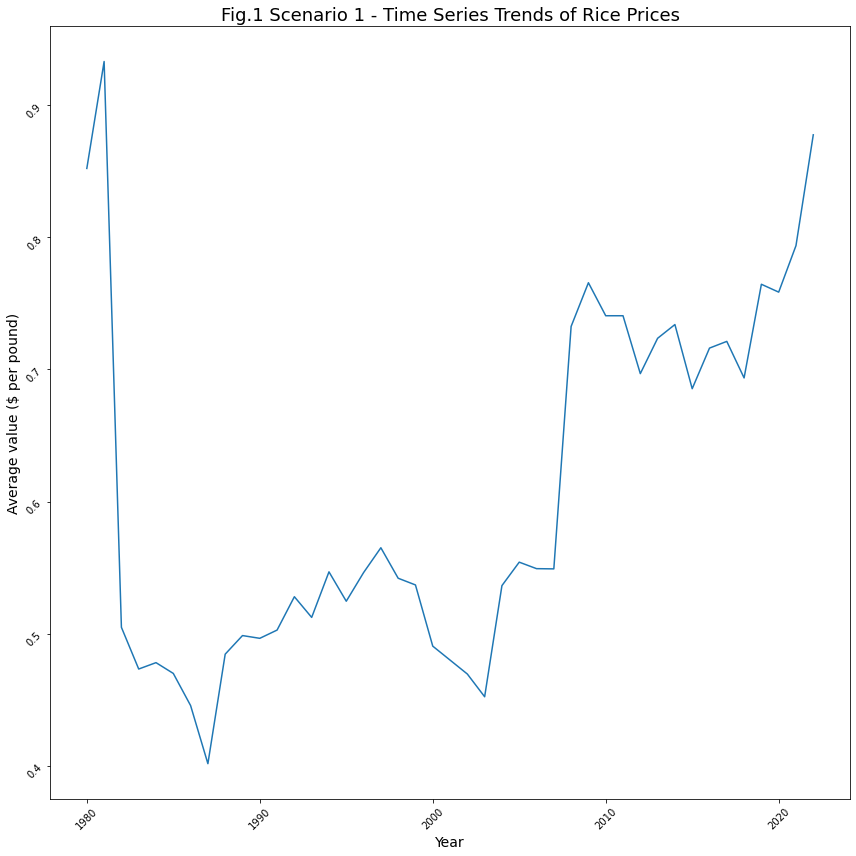

In [47]:
#Construct a line plot with the data
plt.rcParams["figure.figsize"] = [12,12]
plt.rcParams["figure.autolayout"] = True
ax = sns.lineplot(x="year", y="value", data=Avg_value_rice)
ax.tick_params(rotation=45)
ax.set_title('Fig.1 Scenario 1 - Time Series Trends of Rice Prices', fontsize = 18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average value ($ per pound)', fontsize=14)
plt.show()

## Insights for Scenario 1: Effect of Inflation on Rice

Based on the trend in Fig.1, the following insights are observed -

1. After a sharp spike in the price of rice in the year 1980, the price of rice dropped by 0.4 units.
2. In the year 1987 and 2003, the values seem to have dipped compared to the other years. 
3. In the year 1987, the values reached an all-time low.
4. From the year 2020 onwards, we see a sharp spike in the price of rice from 0.75 units approaching towards 0.9 units.

## Scenario 2: How has inflation impacted the price of poultry?

<b> Poultry includes all items that include chicken and eggs. Writing a query to gather data for series_id APU0200FF1101 (chicken breast with bone); APU0300FF1101 (chicken breast boneless); APU0300706111 (Chicken whole); APU0300706211 (Chicken breast); APU0300706212 (Chicken legs); APU0300708111 (Eggs). Note that as per the data, these items are non-seasonally adjusted. The prices are per pound (453.6 gm).</b>

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/tql'

#Construct the request body which has the TQL that is to be used to retrieve the data
# Getting data for series_id APU0200FF1101 (chicken breast with bone); APU0300FF1101 (chicken breast boneless); APU0300706111 (Chicken whole); APU0300706211 (Chicken breast); APU0300706212 (Chicken legs); APU0300708111 (Eggs)
request_body = '[{"name":"Inflation_CPI_Analysis", "stmt":"SELECT * WHERE series_id = \'APU0200FF1101\' OR series_id = \'APU0300FF1101\' OR series_id = \'APU0300706111\' OR series_id = \'APU0300706211\' OR series_id = \'APU0300706212\' OR series_id = \'APU0300708111\' ", "columns":[]}]' 

#Invoke the GridDB WebAPI
data_req2 = requests.post(url, data=request_body, headers=header_obj)
data_req2

We will process the response received from the GridDB WebAPI invocation and construct a dataframe with the data from the response. <br/>
Once done, we will group the data by the year field so that we have the mean values for each year. This can then be plotted to see the trend in a visual manner. 

In [34]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req2.json()
Poultry_trends = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"], myJson[0]["columns"][2]["name"], myJson[0]["columns"][3]["name"],myJson[0]["columns"][4]["name"],myJson[0]["columns"][5]["name"]])

In [35]:
#Group the data on a yearly basis and get the mean value for each year
Avg_value_poultry = pd.DataFrame(Poultry_trends.groupby(['year'])['value'].mean())

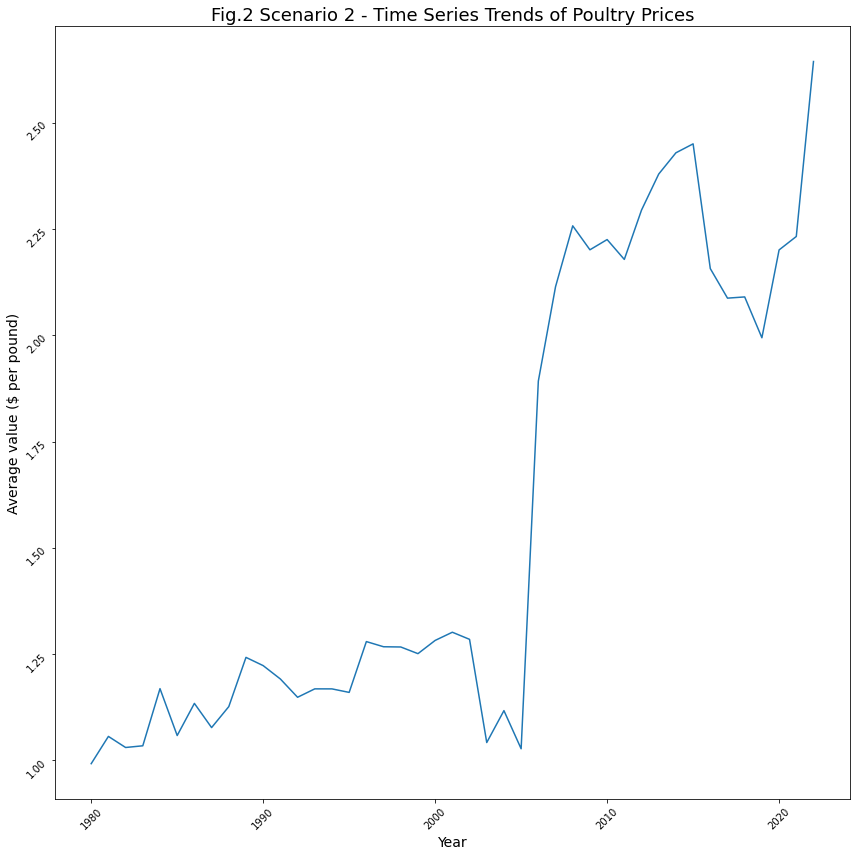

In [48]:
#Construct a line plot with the data
plt.rcParams["figure.figsize"] = [12,12]
plt.rcParams["figure.autolayout"] = True
ax = sns.lineplot(x="year", y="value", data=Avg_value_poultry)
ax.tick_params(rotation=45)
ax.set_title('Fig.2 Scenario 2 - Time Series Trends of Poultry Prices',fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average value ($ per pound)', fontsize=14)
plt.show()

## Insights for Scenario 2: Effect of Inflation on Poultry

We have a very interesting trend here. Based on the trend in Fig.2, the following insights are observed -

1. The average price of poultry was between 1.0 and 2.25 per pound between 1980 and 2005. However, from around 2006 onwards, the price rose to 2.25.
2. After 2006, the price has risen to 2.25 and above.

## Scenario 3: How has inflation impacted milk prices?

<b> The following series_ids are considered - APU0000709111 - Milk, fresh, whole, fortified; APU0000709211 - Milk, fresh, skim; APU0000709212 - Milk, fresh, low fat; APU0200709111 - Milk, fresh, whole, fortified; APU0200709211 - Milk, fresh, skim . Note that only items that are 1.5 gallons and that are not seasonally adjusted have been considered. </b>

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/tql'

#Construct the request body which has the TQL that is to be used to retrieve the data
# Getting data for series_id APU0000709111 - Milk, fresh, whole, fortified; APU0000709211 - Milk, fresh, skim; APU0000709212 - Milk, fresh, low fat; APU0200709111 - Milk, fresh, whole, fortified; APU0200709211 - Milk, fresh, skim
request_body = '[{"name":"Inflation_CPI_Analysis", "stmt":"SELECT * WHERE series_id = \'APU0000709111\' OR series_id = \'APU0000709211\' OR series_id = \'APU0000709212\' OR series_id = \'APU0200709111\' OR series_id = \'APU0200709211\' ", "columns":[]}]' 

#Invoke the GridDB WebAPI
data_req3 = requests.post(url, data=request_body, headers=header_obj)
data_req3

We will process the response received from the GridDB WebAPI invocation and construct a dataframe with the data from the response. <br/>
Once done, we will group the data by the year field so that we have the mean values for each year. This can then be plotted to see the trend in a visual manner. 

In [38]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req3.json()
Milk_trends = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"], myJson[0]["columns"][2]["name"], myJson[0]["columns"][3]["name"],myJson[0]["columns"][4]["name"],myJson[0]["columns"][5]["name"]])

In [39]:
#Group the data by rear and get the mean value for each year
Avg_value_milk = Milk_trends.groupby('year', as_index=False)['value'].mean()

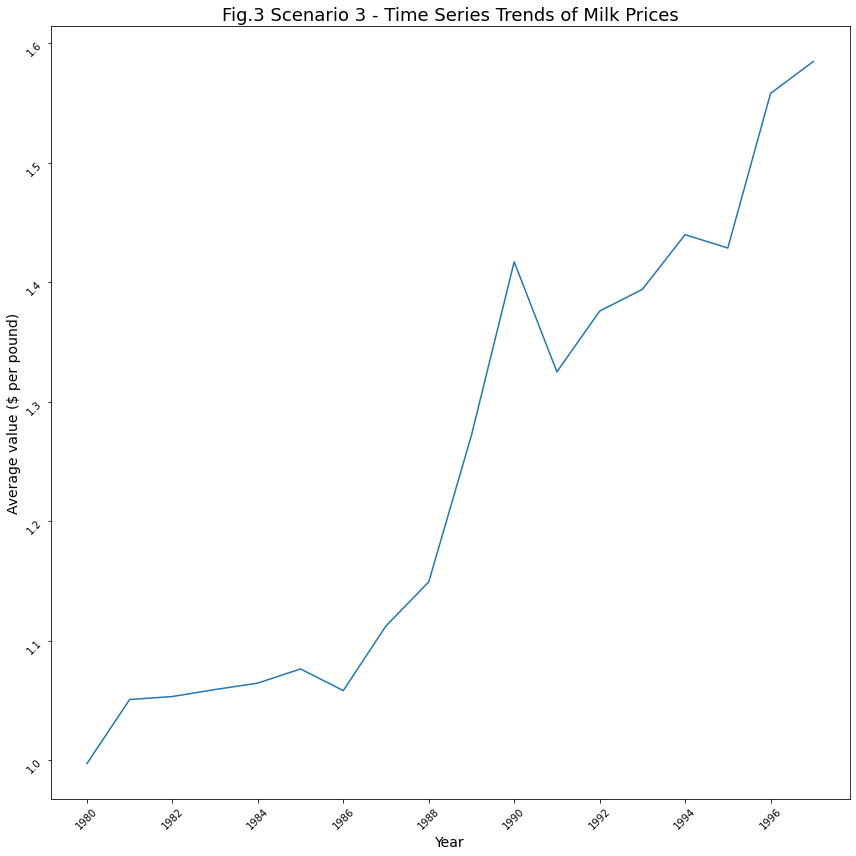

In [49]:
#Construct a line plot with the data; ensure that the ticks on the x axis are integer values
from matplotlib.ticker import MaxNLocator

plt.rcParams["figure.figsize"] = [12,12]
plt.rcParams["figure.autolayout"] = True
#year = (Milk_trends['year'])
ax = sns.lineplot(x="year", y="value", data=Avg_value_milk)
ax.tick_params(rotation=45)
ax.set_title('Fig.3 Scenario 3 - Time Series Trends of Milk Prices',fontsize=18)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average value ($ per pound)', fontsize=14)
plt.show()

## Insights for Scenario 3: Effect of Inflation on Milk

## Scenario 4: How was 2022 in terms of inflation?

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/tql'

#Construct the request body which has the TQL that is to be used to retrieve the data
# Getting data for year 2022
request_body = '[{"name":"Inflation_CPI_Analysis", "stmt":"SELECT * WHERE year = 2022 ", "columns":[]}]' 

#Invoke the GridDB WebAPI
data_req4 = requests.post(url, data=request_body, headers=header_obj)
data_req4

In [42]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req4.json()
year_2022_trends = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"], myJson[0]["columns"][2]["name"], myJson[0]["columns"][3]["name"],myJson[0]["columns"][4]["name"],myJson[0]["columns"][5]["name"]])

C:\Users\mg_su\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


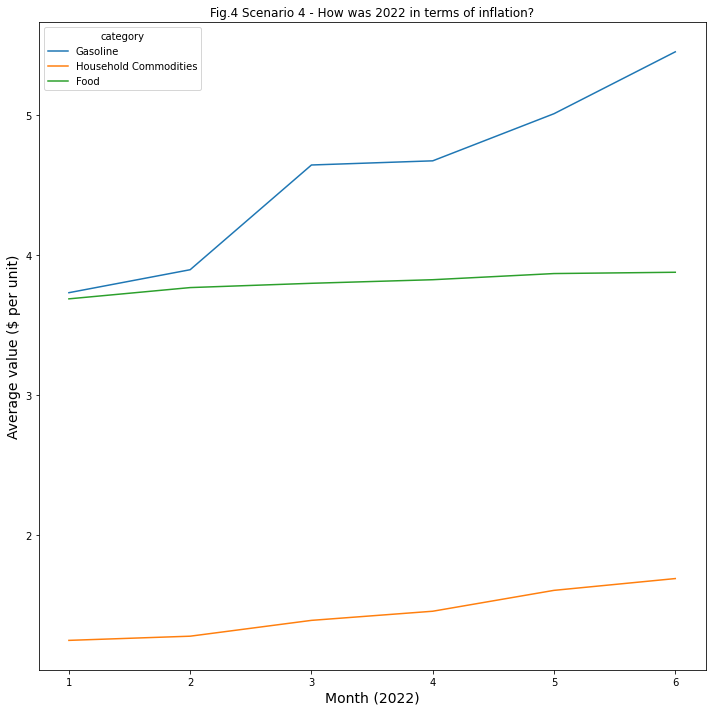

In [43]:
#Construct a Seaborn lineplot with the data to display the trend lines for each category by month
import seaborn
sns.lineplot('month', 'value', ci=None, hue='category', data=year_2022_trends).set(title='Fig.4 Scenario 4 - How was 2022 in terms of inflation?')
plt.xlabel('Month (2022)', fontsize=14)
plt.ylabel('Average value ($ per unit)', fontsize=14)
plt.show()

## Insights for Scenario 4: 2022 & Inflation

## Scenario 5: Has there been a seasonality in the prices of gasoline in the last 20 years?

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/tql'

#Construct the request body which has the TQL that is to be used to retrieve the data
# Getting data for the 'Gasoline' category for the last 20 years
request_body = '[{"name":"Inflation_CPI_Analysis", "stmt":"SELECT * WHERE year >= 2001 and year <= 2022 and category = \'Gasoline\'", "columns":[]}]' 

#Invoke the GridDB WebAPI
data_req5 = requests.post(url, data=request_body, headers=header_obj)
data_req5

In [45]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req5.json()
gasoline_data_20_years = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"], myJson[0]["columns"][2]["name"], myJson[0]["columns"][3]["name"],myJson[0]["columns"][4]["name"],myJson[0]["columns"][5]["name"]])

C:\Users\mg_su\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, '2001'),
  Text(1, 0, '2002'),
  Text(2, 0, '2003'),
  Text(3, 0, '2004'),
  Text(4, 0, '2005'),
  Text(5, 0, '2006'),
  Text(6, 0, '2007'),
  Text(7, 0, '2008'),
  Text(8, 0, '2009'),
  Text(9, 0, '2010'),
  Text(10, 0, '2011'),
  Text(11, 0, '2012'),
  Text(12, 0, '2013'),
  Text(13, 0, '2014'),
  Text(14, 0, '2015'),
  Text(15, 0, '2016'),
  Text(16, 0, '2017'),
  Text(17, 0, '2018'),
  Text(18, 0, '2019'),
  Text(19, 0, '2020'),
  Text(20, 0, '2021'),
  Text(21, 0, '2022')])

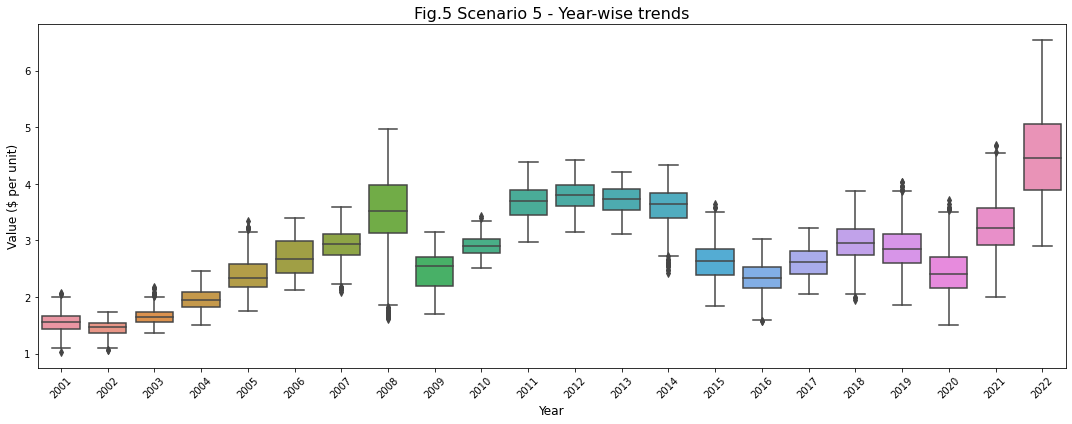

In [46]:
#Construct a boxplot of the year wise trends for the last 20 years
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
sns.boxplot(gasoline_data_20_years['year'], gasoline_data_20_years['value'], ax=ax)
ax.set_title('Fig.5 Scenario 5 - Year-wise trends', fontsize = 16, loc='center')
ax.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('Value ($ per unit)', fontsize = 12)
plt.xticks(rotation=45)

# Insights for Scenario 5: Last 20 years of Inflation

1. No seasonality is observed in the inflation of gasoline prices.
2. However, it is clearly evident that in 2022, inflation is at all time high.
3. As seen from the plot, in 2008, the prices were high for majority of the year. However, there seems to have been a drastic decreases in the prices towards the end of the year. This is evident from the outliers in the box plot for 2008.
4. Between 2019 and 2021, there have been several drastic spikes in gasoline prices as observed by the outliers beyond the upper whisker.

# Concluding Remarks

In the above blogpost, we used GriDB to store large amounts of data and used GridDB's TQL query functionality to retrieve data in an efficient manner. Despite the size of the data, the data load was pretty quick (in seconds). The query times were also pretty minimal and results were retreived in a couple of seconds. We were also able to demonstrate the ease of creating containers in GridDB and running queries against the containers in GridDB.